In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

In [146]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
data = df["Passengers"].values.astype(np.float32)


In [147]:
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [148]:
timesteps = 12
quarter_lag = 3
year_lag = 12

In [149]:
X_recent, X_quarter, X_year, Y = [], [], [], []
for i in range(year_lag + timesteps, len(data)):
    X_recent.append(data[i-timesteps:i])
    X_quarter.append(data[i-quarter_lag-timesteps:i-quarter_lag])
    X_year.append(data[i-year_lag-timesteps:i-year_lag])
    Y.append(data[i])

In [150]:
X_recent = np.array(X_recent).reshape(-1, timesteps, 1)
X_quarter = np.array(X_quarter).reshape(-1, timesteps, 1)
X_year = np.array(X_year).reshape(-1, timesteps, 1)
Y = np.array(Y).reshape(-1, 1)

In [151]:
split = int(len(X_recent)*0.8)
X_recent_train, X_recent_test = X_recent[:split], X_recent[split:]
X_quarter_train, X_quarter_test = X_quarter[:split], X_quarter[split:]
X_year_train, X_year_test = X_year[:split], X_year[split:]
Y_train, Y_test = Y[:split], Y[split:]

In [152]:
scaler = MinMaxScaler()
Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)

In [153]:
input_recent = Input(shape=(timesteps, 1), name="recent_input")
input_quarter = Input(shape=(timesteps, 1), name="quarter_input")
input_year = Input(shape=(timesteps, 1), name="year_input")

lstm_recent = LSTM(8, name="lstm_recent")(input_recent)
lstm_quarter = LSTM(8, name="lstm_quarter")(input_quarter)
lstm_year = LSTM(8, name="lstm_year")(input_year)

output_recent = Dense(1, name="output_recent")(lstm_recent)
output_quarter = Dense(1, name="output_quarter")(lstm_quarter)
output_year = Dense(1, name="output_year")(lstm_year)

merged = Concatenate(name="merged_output")([output_recent, output_quarter, output_year])
final_output = Dense(1, name="final_output")(merged)

model = Model(
    inputs=[input_recent, input_quarter, input_year],
    outputs=[output_recent, output_quarter, output_year, final_output]
)
model.compile(
    optimizer="adam",
    loss={
        "output_recent": "mse",
        "output_quarter": "mse",
        "output_year": "mse",
        "final_output": "mse",
    },
    loss_weights={
        "output_recent": 0.1,
        "output_quarter": 0.1,
        "output_year": 0.1,
        "final_output": 0.7,
    }
)


In [154]:
from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file="multi_input_lstm_model_other_data.png")
print("Model PNG olarak kaydedildi: multi_input_lstm_model.png")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 recent_input (InputLayer)      [(None, 12, 1)]      0           []                               
                                                                                                  
 quarter_input (InputLayer)     [(None, 12, 1)]      0           []                               
                                                                                                  
 year_input (InputLayer)        [(None, 12, 1)]      0           []                               
                                                                                                  
 lstm_recent (LSTM)             (None, 8)            320         ['recent_input[0][0]']           
                                                                                            

In [155]:
history = model.fit(
    [X_recent_train, X_quarter_train, X_year_train],
    [Y_train_scaled, Y_train_scaled, Y_train_scaled, Y_train_scaled],
    epochs=100,
    batch_size=8,
    verbose=1
)


Epoch 1/100
12/12 [==============================] - 2s 10ms/step - loss: 0.1329 - output_recent_loss: 0.0586 - output_quarter_loss: 0.6160 - output_year_loss: 0.1222 - final_output_loss: 0.0761
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1178 - output_recent_loss: 0.0573 - output_quarter_loss: 0.5517 - output_year_loss: 0.1054 - final_output_loss: 0.0662
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0959 - output_recent_loss: 0.0557 - output_quarter_loss: 0.4002 - output_year_loss: 0.0936 - final_output_loss: 0.0585
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0829 - output_recent_loss: 0.0554 - output_quarter_loss: 0.2964 - output_year_loss: 0.0832 - final_output_loss: 0.0563
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0786 - output_recent_loss: 0.0551 - output_quarter_loss: 0.2690 - output_year_loss: 0.0755 - final_output_loss: 0.0552
Epoch 6/100
12/12 [=======

In [156]:
y_pred_scaled = model.predict([X_recent_test, X_quarter_test, X_year_test])
y_pred_final = y_pred_scaled[3]  # final_output
y_pred_final_orig = scaler.inverse_transform(y_pred_final)
Y_test_orig = scaler.inverse_transform(Y_test_scaled)

1/1 [==============================] - 1s 839ms/step


In [157]:
class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Senin tercihine göre ağırlıklar
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.bf = np.ones((hidden_size, 1)) * 1.0  # forget bias = 1
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.dWf = np.zeros_like(self.Wf)
        self.dWi = np.zeros_like(self.Wi)
        self.dWc = np.zeros_like(self.Wc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbf = np.zeros_like(self.bf)
        self.dbi = np.zeros_like(self.bi)
        self.dbc = np.zeros_like(self.bc)
        self.dbo = np.zeros_like(self.bo)

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, out):
        return out * (1 - out)
    def tanh(self, x):
        return np.tanh(x)
    def tanh_derivative(self, out):
        return 1 - out ** 2

    def forward(self, x, h_prev, c_prev):
        combined = np.vstack((h_prev, x))
        f = self.sigmoid(np.dot(self.Wf, combined) + self.bf)
        i = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        c_hat = self.tanh(np.dot(self.Wc, combined) + self.bc)
        o = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        c = f * c_prev + i * c_hat
        h = o * self.tanh(c)
        cache = (x, h_prev, c_prev, f, i, c_hat, o, c, combined)
        return h, c, cache

    def backward(self, dh, dc, cache):
        x, h_prev, c_prev, f, i, c_hat, o, c, combined = cache
        tanh_c = self.tanh(c)
        do = dh * tanh_c
        do_pre = do * self.sigmoid_derivative(o)
        self.dWo += np.dot(do_pre, combined.T)
        self.dbo += do_pre
        dc_total = dc + dh * o * (1 - tanh_c ** 2)
        df = dc_total * c_prev
        df_pre = df * self.sigmoid_derivative(f)
        self.dWf += np.dot(df_pre, combined.T)
        self.dbf += df_pre
        di = dc_total * c_hat
        di_pre = di * self.sigmoid_derivative(i)
        self.dWi += np.dot(di_pre, combined.T)
        self.dbi += di_pre
        dc_hat = dc_total * i
        dc_hat_pre = dc_hat * self.tanh_derivative(c_hat)
        self.dWc += np.dot(dc_hat_pre, combined.T)
        self.dbc += dc_hat_pre
        dc_prev = dc_total * f
        dcombined = (np.dot(self.Wf.T, df_pre) +
                     np.dot(self.Wi.T, di_pre) +
                     np.dot(self.Wc.T, dc_hat_pre) +
                     np.dot(self.Wo.T, do_pre))
        dh_prev = dcombined[:self.hidden_size]
        dx = dcombined[self.hidden_size:]
        return dh_prev, dc_prev, dx

    def update_weights(self, learning_rate):
        self.Wf -= learning_rate * self.dWf
        self.Wi -= learning_rate * self.dWi
        self.Wc -= learning_rate * self.dWc
        self.Wo -= learning_rate * self.dWo
        self.bf -= learning_rate * self.dbf
        self.bi -= learning_rate * self.dbi
        self.bc -= learning_rate * self.dbc
        self.bo -= learning_rate * self.dbo
        self.dWf = np.zeros_like(self.Wf)
        self.dWi = np.zeros_like(self.Wi)
        self.dWc = np.zeros_like(self.Wc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbf = np.zeros_like(self.bf)
        self.dbi = np.zeros_like(self.bi)
        self.dbc = np.zeros_like(self.bc)
        self.dbo = np.zeros_like(self.bo)

In [158]:
class Dense:
    # NumPy ile bir Dense (fully connected) katmanı
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * 0.1
        self.b = np.zeros((output_size, 1))

    def forward(self, x):
        return np.dot(self.W, x) + self.b

    def backward(self, dout, x, lr):
        # x: input, dout: gradient
        self.dW = np.dot(dout, x.T)
        self.db = dout
        self.W -= lr * self.dW
        self.b -= lr * self.db

In [159]:
class CustomLSTMModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.lstm = LSTM(input_size, hidden_size)
        self.dense = Dense(hidden_size, output_size)

    def forward(self, X):
        h = np.zeros((self.lstm.hidden_size, 1))
        c = np.zeros((self.lstm.hidden_size, 1))
        self.caches = []
        for t in range(len(X)):
            x = X[t].reshape(-1, 1)
            h, c, cache = self.lstm.forward(x, h, c)
            self.caches.append(cache)
        y = self.dense.forward(h)
        self.h = h  # For backward
        return y

    def backward(self, dy, lr):
        # Dense backward
        self.dense.backward(dy, self.h, lr)
        # LSTM backward
        dh = np.dot(self.dense.W.T, dy)
        dc = np.zeros_like(self.caches[0][2])
        for t in reversed(range(len(self.caches))):
            dh, dc, dx = self.lstm.backward(dh, dc, self.caches[t])
        self.lstm.update_weights(lr)

    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    def mse_loss_derivative(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_pred.size

    def mae_metric(self, y_pred, y_true):
        return np.mean(np.abs(y_pred - y_true))

In [160]:
class FinalDense:
    # Keras'taki son Dense katmanının numpy versiyonu
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * 0.1
        self.b = np.zeros((output_size, 1))

    def forward(self, x):
        return np.dot(self.W, x) + self.b

    def backward(self, dout, x, lr):
        self.dW = np.dot(dout, x.T)
        self.db = dout
        self.W -= lr * self.dW
        self.b -= lr * self.db

In [161]:
class MultiLSTMModel:
    def __init__(self, recent_model, quarter_model, year_model, tp):
        self.recent_model = recent_model    # output_recent
        self.quarter_model = quarter_model  # output_quarter
        self.year_model = year_model        # output_year
        self.final_dense = FinalDense(tp * 3, tp)  # 3 output'u birleştir, tp boyutunda final_output
        self.learning_rate = 0.01

    def forward(self, recent_data, quarter_data, year_data):
        out_recent = self.recent_model.forward(recent_data)
        out_quarter = self.quarter_model.forward(quarter_data)
        out_year = self.year_model.forward(year_data)
        merged = np.vstack([out_recent, out_quarter, out_year])
        final_output = self.final_dense.forward(merged)
        return {
            "output_recent": out_recent,
            "output_quarter": out_quarter,
            "output_year": out_year,
            "merged": merged,
            "final_output": final_output
        }

    def compute_loss(self, outputs, targets):
        losses = {
            "output_recent": self.recent_model.mse_loss(outputs["output_recent"], targets["output_recent"]),
            "output_quarter": self.quarter_model.mse_loss(outputs["output_quarter"], targets["output_quarter"]),
            "output_year": self.year_model.mse_loss(outputs["output_year"], targets["output_year"]),
            "final_output": self.recent_model.mse_loss(outputs["final_output"], targets["final_output"])
        }
        maes = {
            "output_recent": self.recent_model.mae_metric(outputs["output_recent"], targets["output_recent"]),
            "output_quarter": self.quarter_model.mae_metric(outputs["output_quarter"], targets["output_quarter"]),
            "output_year": self.year_model.mae_metric(outputs["output_year"], targets["output_year"]),
            "final_output": self.recent_model.mae_metric(outputs["final_output"], targets["final_output"])
        }
        loss_weights = {
            "output_recent": 0.1,
            "output_quarter": 0.1,
            "output_year": 0.1,
            "final_output": 0.7
        }
        total_loss = sum(losses[key] * loss_weights[key] for key in losses)
        return total_loss, losses, maes

    def train_step(self, recent_data, quarter_data, year_data, targets):
        outputs = self.forward(recent_data, quarter_data, year_data)
        total_loss, losses, maes = self.compute_loss(outputs, targets)
        dy_recent = self.recent_model.mse_loss_derivative(outputs["output_recent"], targets["output_recent"])
        dy_quarter = self.quarter_model.mse_loss_derivative(outputs["output_quarter"], targets["output_quarter"])
        dy_year = self.year_model.mse_loss_derivative(outputs["output_year"], targets["output_year"])
        dy_final = self.recent_model.mse_loss_derivative(outputs["final_output"], targets["final_output"])

        self.final_dense.backward(dy_final, outputs["merged"], self.learning_rate)
        dmerged = np.dot(self.final_dense.W.T, dy_final)
        dmerged_recent = dmerged[0:outputs["output_recent"].shape[0]]
        dmerged_quarter = dmerged[outputs["output_recent"].shape[0]:outputs["output_recent"].shape[0]+outputs["output_quarter"].shape[0]]
        dmerged_year = dmerged[-outputs["output_year"].shape[0]:]

        self.recent_model.backward(dy_recent * 0.1 + dmerged_recent * 0.7, self.learning_rate)
        self.quarter_model.backward(dy_quarter * 0.1 + dmerged_quarter * 0.7, self.learning_rate)
        self.year_model.backward(dy_year * 0.1 + dmerged_year * 0.7, self.learning_rate)
        return total_loss, losses, maes


In [162]:
tp = 1
recent_model = CustomLSTMModel(input_size=1, hidden_size=8, output_size=tp)
quarter_model = CustomLSTMModel(input_size=1, hidden_size=8, output_size=tp)
year_model = CustomLSTMModel(input_size=1, hidden_size=8, output_size=tp)
multi_numpy = MultiLSTMModel(recent_model, quarter_model, year_model, tp)

In [163]:
epochs = 100
for epoch in range(epochs):
    losses = []
    for i in range(len(X_recent_train)):
        targets = {
            "output_recent": Y_train_scaled[i].reshape(-1, 1),
            "output_quarter": Y_train_scaled[i].reshape(-1, 1),
            "output_year": Y_train_scaled[i].reshape(-1, 1),
            "final_output": Y_train_scaled[i].reshape(-1, 1)
        }
        total_loss, _, _ = multi_numpy.train_step(
            X_recent_train[i],
            X_quarter_train[i],
            X_year_train[i],
            targets
        )
        losses.append(total_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.6f}")

Epoch 1/100, Loss: 0.079465
Epoch 10/100, Loss: 0.050895
Epoch 20/100, Loss: 0.052348
Epoch 30/100, Loss: 0.052447
Epoch 40/100, Loss: 0.052528
Epoch 50/100, Loss: 0.052486
Epoch 60/100, Loss: 0.052324
Epoch 70/100, Loss: 0.052207
Epoch 80/100, Loss: 0.052066
Epoch 90/100, Loss: 0.051865
Epoch 100/100, Loss: 0.051400


In [164]:
# Test
y_pred_numpy_scaled = []
for i in range(len(X_recent_test)):
    outputs = multi_numpy.forward(
        X_recent_test[i],
        X_quarter_test[i],
        X_year_test[i]
    )
    y_pred_numpy_scaled.append(outputs["final_output"].flatten())
y_pred_numpy_scaled = np.array(y_pred_numpy_scaled)
y_pred_numpy = scaler.inverse_transform(y_pred_numpy_scaled)

In [165]:
rmse_keras = np.sqrt(mean_squared_error(Y_test_orig, y_pred_final_orig))
rmse_numpy = np.sqrt(mean_squared_error(Y_test_orig, y_pred_numpy))
r2_keras = r2_score(Y_test_orig, y_pred_final_orig)
r2_numpy = r2_score(Y_test_orig, y_pred_numpy)

print("\n--- Karşılaştırmalı Sonuçlar Tablosu (Gerçek Yolcu Sayısı ile) ---")
results = pd.DataFrame({
    "Model": ["NumPy Multi-Input LSTM", "Keras Multi-Input LSTM"],
    "RMSE": [rmse_numpy, rmse_keras],
    "R2": [r2_numpy, r2_keras]
})
print(results)


--- Karşılaştırmalı Sonuçlar Tablosu (Gerçek Yolcu Sayısı ile) ---
                    Model        RMSE        R2
0  NumPy Multi-Input LSTM  142.362407 -2.634247
1  Keras Multi-Input LSTM   91.161108 -0.490195


In [166]:
print("İlk 10 gerçek:", np.round(Y_test_orig.flatten()[:10],1))
print("İlk 10 NumPy:", np.round(y_pred_numpy.flatten()[:10],1))
print("İlk 10 Keras:", np.round(y_pred_final_orig.flatten()[:10],1))

İlk 10 gerçek: [360. 342. 406. 396. 420. 472. 548. 559. 463. 407.]
İlk 10 NumPy: [331.  331.  331.  331.  331.  331.  331.1 331.1 331.1 331. ]
İlk 10 Keras: [384.7 386.  386.9 388.9 389.5 391.2 392.5 393.6 393.8 392.8]


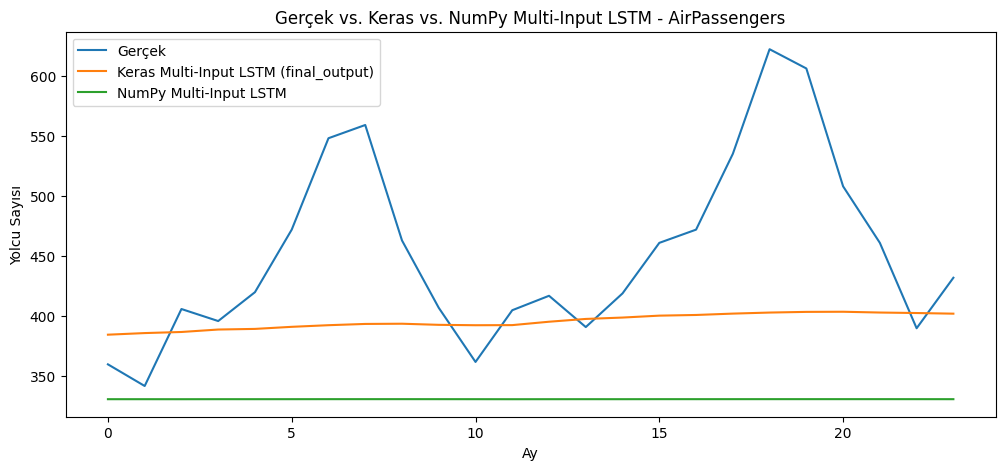

In [167]:
plt.figure(figsize=(12,5))
plt.plot(Y_test_orig[:24], label="Gerçek")
plt.plot(y_pred_final_orig[:24], label="Keras Multi-Input LSTM (final_output)")
plt.plot(y_pred_numpy[:24], label="NumPy Multi-Input LSTM")
plt.legend()
plt.title("Gerçek vs. Keras vs. NumPy Multi-Input LSTM - AirPassengers")
plt.xlabel("Ay")
plt.ylabel("Yolcu Sayısı")
plt.show()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 recent_input (InputLayer)      [(None, 12, 1)]      0           []                               
                                                                                                  
 quarter_input (InputLayer)     [(None, 12, 1)]      0           []                               
                                                                                                  
 year_input (InputLayer)        [(None, 12, 1)]      0           []                               
                                                                                                  
 lstm_recent (LSTM)             (None, 64)           16896       ['recent_input[0][0]']           
                                                                                            

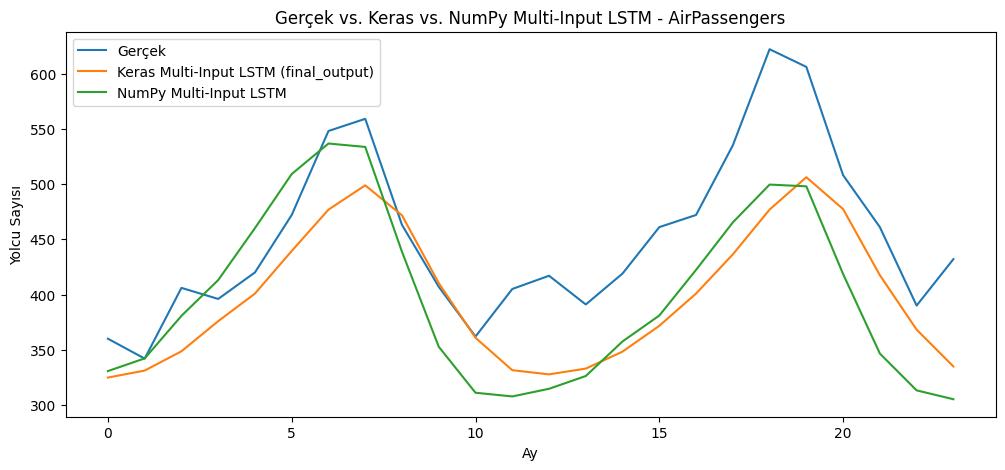

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# --- VERİ YÜKLEME ---
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
data = df["Passengers"].values.astype(np.float32)

timesteps = 12
quarter_lag = 3
year_lag = 12
X_recent, X_quarter, X_year, Y = [], [], [], []
for i in range(year_lag + timesteps, len(data)):
    X_recent.append(data[i-timesteps:i])
    X_quarter.append(data[i-quarter_lag-timesteps:i-quarter_lag])
    X_year.append(data[i-year_lag-timesteps:i-year_lag])
    Y.append(data[i])
X_recent = np.array(X_recent).reshape(-1, timesteps, 1)
X_quarter = np.array(X_quarter).reshape(-1, timesteps, 1)
X_year = np.array(X_year).reshape(-1, timesteps, 1)
Y = np.array(Y).reshape(-1, 1)

split = int(len(X_recent)*0.8)
X_recent_train, X_recent_test = X_recent[:split], X_recent[split:]
X_quarter_train, X_quarter_test = X_quarter[:split], X_quarter[split:]
X_year_train, X_year_test = X_year[:split], X_year[split:]
Y_train, Y_test = Y[:split], Y[split:]

# --- SCALER İŞLEMLERİ ---
# Y için scaler
scaler_y = MinMaxScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

# X'ler için scaler (her bir input için ayrı scaler kullanmak daha iyi)
def fit_reshape_scaler(X_train, X_test):
    nsamples, ntimesteps, nfeat = X_train.shape
    scaler = MinMaxScaler()
    X_train_rs = X_train.reshape(-1, 1)
    X_test_rs = X_test.reshape(-1, 1)
    X_train_scaled = scaler.fit_transform(X_train_rs).reshape(nsamples, ntimesteps, nfeat)
    X_test_scaled = scaler.transform(X_test_rs).reshape(X_test.shape)
    return X_train_scaled, X_test_scaled, scaler

X_recent_train_scaled, X_recent_test_scaled, scaler_recent = fit_reshape_scaler(X_recent_train, X_recent_test)
X_quarter_train_scaled, X_quarter_test_scaled, scaler_quarter = fit_reshape_scaler(X_quarter_train, X_quarter_test)
X_year_train_scaled, X_year_test_scaled, scaler_year = fit_reshape_scaler(X_year_train, X_year_test)

# --- KERAS MODELİ ---
input_recent = Input(shape=(timesteps, 1), name="recent_input")
input_quarter = Input(shape=(timesteps, 1), name="quarter_input")
input_year = Input(shape=(timesteps, 1), name="year_input")

lstm_recent = LSTM(64, name="lstm_recent")(input_recent)
lstm_quarter = LSTM(32, name="lstm_quarter")(input_quarter)
lstm_year = LSTM(32, name="lstm_year")(input_year)

output_recent = Dense(1, name="output_recent")(lstm_recent)
output_quarter = Dense(1, name="output_quarter")(lstm_quarter)
output_year = Dense(1, name="output_year")(lstm_year)

merged = Concatenate(name="merged_output")([output_recent, output_quarter, output_year])
final_output = Dense(1, name="final_output")(merged)

model = Model(
    inputs=[input_recent, input_quarter, input_year],
    outputs=[output_recent, output_quarter, output_year, final_output]
)
model.compile(
    optimizer="adam",
    loss={
        "output_recent": "mse",
        "output_quarter": "mse",
        "output_year": "mse",
        "final_output": "mse",
    },
    loss_weights={
        "output_recent": 0.1,
        "output_quarter": 0.1,
        "output_year": 0.1,
        "final_output": 0.7,
    }
)

from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file="multi_input_lstm_model_other_data.png")
print("Model PNG olarak kaydedildi: multi_input_lstm_model_other_data.png")

history = model.fit(
    [X_recent_train_scaled, X_quarter_train_scaled, X_year_train_scaled],
    [Y_train_scaled, Y_train_scaled, Y_train_scaled, Y_train_scaled],
    epochs=100,
    batch_size=8,
    verbose=1
)

y_pred_scaled = model.predict([X_recent_test_scaled, X_quarter_test_scaled, X_year_test_scaled])
y_pred_final = y_pred_scaled[3]  # final_output
y_pred_final_orig = scaler_y.inverse_transform(y_pred_final)
Y_test_orig = scaler_y.inverse_transform(Y_test_scaled)

# --- NumPy Multi-Input LSTM MODELİ ---
class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.2
        self.bf = np.ones((hidden_size, 1)) * 1.0  # forget bias = 1
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.dWf = np.zeros_like(self.Wf)
        self.dWi = np.zeros_like(self.Wi)
        self.dWc = np.zeros_like(self.Wc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbf = np.zeros_like(self.bf)
        self.dbi = np.zeros_like(self.bi)
        self.dbc = np.zeros_like(self.bc)
        self.dbo = np.zeros_like(self.bo)

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, out):
        return out * (1 - out)
    def tanh(self, x):
        return np.tanh(x)
    def tanh_derivative(self, out):
        return 1 - out ** 2

    def forward(self, x, h_prev, c_prev):
        combined = np.vstack((h_prev, x))
        f = self.sigmoid(np.dot(self.Wf, combined) + self.bf)
        i = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        c_hat = self.tanh(np.dot(self.Wc, combined) + self.bc)
        o = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        c = f * c_prev + i * c_hat
        h = o * self.tanh(c)
        cache = (x, h_prev, c_prev, f, i, c_hat, o, c, combined)
        return h, c, cache

    def backward(self, dh, dc, cache):
        x, h_prev, c_prev, f, i, c_hat, o, c, combined = cache
        tanh_c = self.tanh(c)
        do = dh * tanh_c
        do_pre = do * self.sigmoid_derivative(o)
        self.dWo += np.dot(do_pre, combined.T)
        self.dbo += do_pre
        dc_total = dc + dh * o * (1 - tanh_c ** 2)
        df = dc_total * c_prev
        df_pre = df * self.sigmoid_derivative(f)
        self.dWf += np.dot(df_pre, combined.T)
        self.dbf += df_pre
        di = dc_total * c_hat
        di_pre = di * self.sigmoid_derivative(i)
        self.dWi += np.dot(di_pre, combined.T)
        self.dbi += di_pre
        dc_hat = dc_total * i
        dc_hat_pre = dc_hat * self.tanh_derivative(c_hat)
        self.dWc += np.dot(dc_hat_pre, combined.T)
        self.dbc += dc_hat_pre
        dc_prev = dc_total * f
        dcombined = (np.dot(self.Wf.T, df_pre) +
                     np.dot(self.Wi.T, di_pre) +
                     np.dot(self.Wc.T, dc_hat_pre) +
                     np.dot(self.Wo.T, do_pre))
        dh_prev = dcombined[:self.hidden_size]
        dx = dcombined[self.hidden_size:]
        return dh_prev, dc_prev, dx

    def update_weights(self, learning_rate):
        self.Wf -= learning_rate * self.dWf
        self.Wi -= learning_rate * self.dWi
        self.Wc -= learning_rate * self.dWc
        self.Wo -= learning_rate * self.dWo
        self.bf -= learning_rate * self.dbf
        self.bi -= learning_rate * self.dbi
        self.bc -= learning_rate * self.dbc
        self.bo -= learning_rate * self.dbo
        self.dWf = np.zeros_like(self.Wf)
        self.dWi = np.zeros_like(self.Wi)
        self.dWc = np.zeros_like(self.Wc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbf = np.zeros_like(self.bf)
        self.dbi = np.zeros_like(self.bi)
        self.dbc = np.zeros_like(self.bc)
        self.dbo = np.zeros_like(self.bo)
class Dense:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * 0.1
        self.b = np.zeros((output_size, 1))
    def forward(self, x):
        return np.dot(self.W, x) + self.b
    def backward(self, dout, x, lr):
        self.dW = np.dot(dout, x.T)
        self.db = dout
        self.W -= lr * self.dW
        self.b -= lr * self.db
class CustomLSTMModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.lstm = LSTM(input_size, hidden_size)
        self.dense = Dense(hidden_size, output_size)
    def forward(self, X):
        h = np.zeros((self.lstm.hidden_size, 1))
        c = np.zeros((self.lstm.hidden_size, 1))
        self.caches = []
        for t in range(len(X)):
            x = X[t].reshape(-1, 1)
            h, c, cache = self.lstm.forward(x, h, c)
            self.caches.append(cache)
        y = self.dense.forward(h)
        self.h = h
        return y
    def backward(self, dy, lr):
        self.dense.backward(dy, self.h, lr)
        dh = np.dot(self.dense.W.T, dy)
        dc = np.zeros_like(self.caches[0][2])
        for t in reversed(range(len(self.caches))):
            dh, dc, dx = self.lstm.backward(dh, dc, self.caches[t])
        self.lstm.update_weights(lr)
    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)
    def mse_loss_derivative(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_pred.size
    def mae_metric(self, y_pred, y_true):
        return np.mean(np.abs(y_pred - y_true))
class FinalDense:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * 0.1
        self.b = np.zeros((output_size, 1))
    def forward(self, x):
        return np.dot(self.W, x) + self.b
    def backward(self, dout, x, lr):
        self.dW = np.dot(dout, x.T)
        self.db = dout
        self.W -= lr * self.dW
        self.b -= lr * self.db
class MultiLSTMModel:
    def __init__(self, recent_model, quarter_model, year_model, tp):
        self.recent_model = recent_model
        self.quarter_model = quarter_model
        self.year_model = year_model
        self.final_dense = FinalDense(tp * 3, tp)
        self.learning_rate = 0.01
    def forward(self, recent_data, quarter_data, year_data):
        out_recent = self.recent_model.forward(recent_data)
        out_quarter = self.quarter_model.forward(quarter_data)
        out_year = self.year_model.forward(year_data)
        merged = np.vstack([out_recent, out_quarter, out_year])
        final_output = self.final_dense.forward(merged)
        return {
            "output_recent": out_recent,
            "output_quarter": out_quarter,
            "output_year": out_year,
            "merged": merged,
            "final_output": final_output
        }
    def compute_loss(self, outputs, targets):
        losses = {
            "output_recent": self.recent_model.mse_loss(outputs["output_recent"], targets["output_recent"]),
            "output_quarter": self.quarter_model.mse_loss(outputs["output_quarter"], targets["output_quarter"]),
            "output_year": self.year_model.mse_loss(outputs["output_year"], targets["output_year"]),
            "final_output": self.recent_model.mse_loss(outputs["final_output"], targets["final_output"])
        }
        maes = {
            "output_recent": self.recent_model.mae_metric(outputs["output_recent"], targets["output_recent"]),
            "output_quarter": self.quarter_model.mae_metric(outputs["output_quarter"], targets["output_quarter"]),
            "output_year": self.year_model.mae_metric(outputs["output_year"], targets["output_year"]),
            "final_output": self.recent_model.mae_metric(outputs["final_output"], targets["final_output"])
        }
        loss_weights = {
            "output_recent": 0.1,
            "output_quarter": 0.1,
            "output_year": 0.1,
            "final_output": 0.7
        }
        total_loss = sum(losses[key] * loss_weights[key] for key in losses)
        return total_loss, losses, maes
    def train_step(self, recent_data, quarter_data, year_data, targets):
        outputs = self.forward(recent_data, quarter_data, year_data)
        total_loss, losses, maes = self.compute_loss(outputs, targets)
        dy_recent = self.recent_model.mse_loss_derivative(outputs["output_recent"], targets["output_recent"])
        dy_quarter = self.quarter_model.mse_loss_derivative(outputs["output_quarter"], targets["output_quarter"])
        dy_year = self.year_model.mse_loss_derivative(outputs["output_year"], targets["output_year"])
        dy_final = self.recent_model.mse_loss_derivative(outputs["final_output"], targets["final_output"])
        self.final_dense.backward(dy_final, outputs["merged"], self.learning_rate)
        dmerged = np.dot(self.final_dense.W.T, dy_final)
        dmerged_recent = dmerged[0:outputs["output_recent"].shape[0]]
        dmerged_quarter = dmerged[outputs["output_recent"].shape[0]:outputs["output_recent"].shape[0]+outputs["output_quarter"].shape[0]]
        dmerged_year = dmerged[-outputs["output_year"].shape[0]:]
        self.recent_model.backward(dy_recent * 0.1 + dmerged_recent * 0.7, self.learning_rate)
        self.quarter_model.backward(dy_quarter * 0.1 + dmerged_quarter * 0.7, self.learning_rate)
        self.year_model.backward(dy_year * 0.1 + dmerged_year * 0.7, self.learning_rate)
        return total_loss, losses, maes

tp = 1
recent_model = CustomLSTMModel(input_size=1, hidden_size=64, output_size=tp)
quarter_model = CustomLSTMModel(input_size=1, hidden_size=32, output_size=tp)
year_model = CustomLSTMModel(input_size=1, hidden_size=32, output_size=tp)
multi_numpy = MultiLSTMModel(recent_model, quarter_model, year_model, tp)
epochs = 100
for epoch in range(epochs):
    losses = []
    for i in range(len(X_recent_train_scaled)):
        targets = {
            "output_recent": Y_train_scaled[i].reshape(-1, 1),
            "output_quarter": Y_train_scaled[i].reshape(-1, 1),
            "output_year": Y_train_scaled[i].reshape(-1, 1),
            "final_output": Y_train_scaled[i].reshape(-1, 1)
        }
        total_loss, _, _ = multi_numpy.train_step(
            X_recent_train_scaled[i],
            X_quarter_train_scaled[i],
            X_year_train_scaled[i],
            targets
        )
        losses.append(total_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.6f}")

# Test
y_pred_numpy_scaled = []
for i in range(len(X_recent_test_scaled)):
    outputs = multi_numpy.forward(
        X_recent_test_scaled[i],
        X_quarter_test_scaled[i],
        X_year_test_scaled[i]
    )
    y_pred_numpy_scaled.append(outputs["final_output"].flatten())
y_pred_numpy_scaled = np.array(y_pred_numpy_scaled)
y_pred_numpy = scaler_y.inverse_transform(y_pred_numpy_scaled)

rmse_keras = np.sqrt(mean_squared_error(Y_test_orig, y_pred_final_orig))
rmse_numpy = np.sqrt(mean_squared_error(Y_test_orig, y_pred_numpy))
r2_keras = r2_score(Y_test_orig, y_pred_final_orig)
r2_numpy = r2_score(Y_test_orig, y_pred_numpy)

print("\n--- Karşılaştırmalı Sonuçlar Tablosu (Gerçek Yolcu Sayısı ile) ---")
results = pd.DataFrame({
    "Model": ["NumPy Multi-Input LSTM", "Keras Multi-Input LSTM"],
    "RMSE": [rmse_numpy, rmse_keras],
    "R2": [r2_numpy, r2_keras]
})
print(results)
print("İlk 10 gerçek:", np.round(Y_test_orig.flatten()[:10],1))
print("İlk 10 NumPy:", np.round(y_pred_numpy.flatten()[:10],1))
print("İlk 10 Keras:", np.round(y_pred_final_orig.flatten()[:10],1))

plt.figure(figsize=(12,5))
plt.plot(Y_test_orig[:24], label="Gerçek")
plt.plot(y_pred_final_orig[:24], label="Keras Multi-Input LSTM (final_output)")
plt.plot(y_pred_numpy[:24], label="NumPy Multi-Input LSTM")
plt.legend()
plt.title("Gerçek vs. Keras vs. NumPy Multi-Input LSTM - AirPassengers")
plt.xlabel("Ay")
plt.ylabel("Yolcu Sayısı")
plt.show()
